# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 12            
model_seed = 2           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 5000
dataset_type = "poison"   
dataset_quantities = [0, 100, 500, 1000, 2000]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_model_data as model_module  # <- your new module for CIFAR-10

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CIFAR-10 MLP initialization parameters
# Since input dimension is higher, hidden layers can be larger
hidden_dims = [512, 256]  # adjust as desired

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3059 | Test Loss 2.1122 | accs Train 0.1162 Test 0.2557


Epoch 100/2000: Train Loss 0.0240 | Test Loss 2.9523 | accs Train 1.0000 Test 0.4123


Epoch 200/2000: Train Loss 0.0031 | Test Loss 3.7076 | accs Train 1.0000 Test 0.4130


Epoch 300/2000: Train Loss 0.0013 | Test Loss 4.0622 | accs Train 1.0000 Test 0.4124


Epoch 400/2000: Train Loss 0.0007 | Test Loss 4.3246 | accs Train 1.0000 Test 0.4115


Epoch 500/2000: Train Loss 0.0004 | Test Loss 4.5258 | accs Train 1.0000 Test 0.4115


Epoch 600/2000: Train Loss 0.0003 | Test Loss 4.6887 | accs Train 1.0000 Test 0.4107


Epoch 700/2000: Train Loss 0.0002 | Test Loss 4.8247 | accs Train 1.0000 Test 0.4099


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.9413 | accs Train 1.0000 Test 0.4097


Epoch 900/2000: Train Loss 0.0001 | Test Loss 5.0450 | accs Train 1.0000 Test 0.4094


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.1372 | accs Train 1.0000 Test 0.4082


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.2214 | accs Train 1.0000 Test 0.4080


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.2990 | accs Train 1.0000 Test 0.4077


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.3707 | accs Train 1.0000 Test 0.4079


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 5.4369 | accs Train 1.0000 Test 0.4079


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 5.4985 | accs Train 1.0000 Test 0.4084


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 5.5560 | accs Train 1.0000 Test 0.4082


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.6107 | accs Train 1.0000 Test 0.4086


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.6622 | accs Train 1.0000 Test 0.4085


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.7117 | accs Train 1.0000 Test 0.4081


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.7589 | accs Train 1.0000 Test 0.4082
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 2.3058 | Test Loss 2.1127 | accs Train 0.1161 Test 0.2561


Epoch 100/2000: Train Loss 0.0310 | Test Loss 2.8498 | accs Train 0.9994 Test 0.4073


Epoch 200/2000: Train Loss 0.0037 | Test Loss 3.6270 | accs Train 1.0000 Test 0.4050


Epoch 300/2000: Train Loss 0.0015 | Test Loss 3.9655 | accs Train 1.0000 Test 0.4043


Epoch 400/2000: Train Loss 0.0009 | Test Loss 4.1923 | accs Train 1.0000 Test 0.4035


Epoch 500/2000: Train Loss 0.0005 | Test Loss 4.3642 | accs Train 1.0000 Test 0.4027


Epoch 600/2000: Train Loss 0.0004 | Test Loss 4.5042 | accs Train 1.0000 Test 0.4016


Epoch 700/2000: Train Loss 0.0003 | Test Loss 4.6214 | accs Train 1.0000 Test 0.4015


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.7237 | accs Train 1.0000 Test 0.4008


Epoch 900/2000: Train Loss 0.0002 | Test Loss 4.8127 | accs Train 1.0000 Test 0.4011


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 4.8927 | accs Train 1.0000 Test 0.4012


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 4.9651 | accs Train 1.0000 Test 0.4014


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.0314 | accs Train 1.0000 Test 0.4017


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.0928 | accs Train 1.0000 Test 0.4019


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.1492 | accs Train 1.0000 Test 0.4018


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.2018 | accs Train 1.0000 Test 0.4016


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.2513 | accs Train 1.0000 Test 0.4016


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.2978 | accs Train 1.0000 Test 0.4016


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.3420 | accs Train 1.0000 Test 0.4016


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.3844 | accs Train 1.0000 Test 0.4016


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.4253 | accs Train 1.0000 Test 0.4017
Completed training with 100 additional samples of poison
Epoch 1/2000: Train Loss 2.3061 | Test Loss 2.1115 | accs Train 0.1135 Test 0.2556


Epoch 100/2000: Train Loss 0.0547 | Test Loss 2.6940 | accs Train 0.9984 Test 0.3875


Epoch 200/2000: Train Loss 0.0059 | Test Loss 3.5007 | accs Train 1.0000 Test 0.3879


Epoch 300/2000: Train Loss 0.0023 | Test Loss 3.8563 | accs Train 1.0000 Test 0.3872


Epoch 400/2000: Train Loss 0.0013 | Test Loss 4.0939 | accs Train 1.0000 Test 0.3869


Epoch 500/2000: Train Loss 0.0008 | Test Loss 4.2805 | accs Train 1.0000 Test 0.3873


Epoch 600/2000: Train Loss 0.0006 | Test Loss 4.4306 | accs Train 1.0000 Test 0.3866


Epoch 700/2000: Train Loss 0.0004 | Test Loss 4.5555 | accs Train 1.0000 Test 0.3859


Epoch 800/2000: Train Loss 0.0003 | Test Loss 4.6642 | accs Train 1.0000 Test 0.3856


Epoch 900/2000: Train Loss 0.0002 | Test Loss 4.7597 | accs Train 1.0000 Test 0.3859


Epoch 1000/2000: Train Loss 0.0002 | Test Loss 4.8445 | accs Train 1.0000 Test 0.3866


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 4.9213 | accs Train 1.0000 Test 0.3864


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 4.9915 | accs Train 1.0000 Test 0.3859


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.0560 | accs Train 1.0000 Test 0.3860


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.1154 | accs Train 1.0000 Test 0.3865


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.1712 | accs Train 1.0000 Test 0.3857


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.2243 | accs Train 1.0000 Test 0.3855


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.2744 | accs Train 1.0000 Test 0.3852


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.3216 | accs Train 1.0000 Test 0.3854


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.3663 | accs Train 1.0000 Test 0.3857


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.4092 | accs Train 1.0000 Test 0.3860
Completed training with 500 additional samples of poison
Epoch 1/2000: Train Loss 2.3066 | Test Loss 2.1128 | accs Train 0.1118 Test 0.2539


Epoch 100/2000: Train Loss 0.0918 | Test Loss 2.6889 | accs Train 0.9950 Test 0.3710


Epoch 200/2000: Train Loss 0.0083 | Test Loss 3.5595 | accs Train 1.0000 Test 0.3698


Epoch 300/2000: Train Loss 0.0032 | Test Loss 3.9614 | accs Train 1.0000 Test 0.3684


Epoch 400/2000: Train Loss 0.0017 | Test Loss 4.2277 | accs Train 1.0000 Test 0.3686


Epoch 500/2000: Train Loss 0.0011 | Test Loss 4.4287 | accs Train 1.0000 Test 0.3660


Epoch 600/2000: Train Loss 0.0007 | Test Loss 4.5894 | accs Train 1.0000 Test 0.3658


Epoch 700/2000: Train Loss 0.0005 | Test Loss 4.7228 | accs Train 1.0000 Test 0.3660


Epoch 800/2000: Train Loss 0.0004 | Test Loss 4.8367 | accs Train 1.0000 Test 0.3653


Epoch 900/2000: Train Loss 0.0003 | Test Loss 4.9368 | accs Train 1.0000 Test 0.3649


Epoch 1000/2000: Train Loss 0.0003 | Test Loss 5.0267 | accs Train 1.0000 Test 0.3645


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 5.1089 | accs Train 1.0000 Test 0.3644


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 5.1837 | accs Train 1.0000 Test 0.3646


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 5.2532 | accs Train 1.0000 Test 0.3650


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.3171 | accs Train 1.0000 Test 0.3647


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.3768 | accs Train 1.0000 Test 0.3645


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.4333 | accs Train 1.0000 Test 0.3648


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.4869 | accs Train 1.0000 Test 0.3651


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.5371 | accs Train 1.0000 Test 0.3647


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.5850 | accs Train 1.0000 Test 0.3646


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 5.6309 | accs Train 1.0000 Test 0.3643
Completed training with 1000 additional samples of poison
Epoch 1/2000: Train Loss 2.3075 | Test Loss 2.1149 | accs Train 0.1079 Test 0.2574


Epoch 100/2000: Train Loss 0.1765 | Test Loss 2.5634 | accs Train 0.9844 Test 0.3438


Epoch 200/2000: Train Loss 0.0162 | Test Loss 3.5310 | accs Train 1.0000 Test 0.3367


Epoch 300/2000: Train Loss 0.0056 | Test Loss 3.9972 | accs Train 1.0000 Test 0.3329


Epoch 400/2000: Train Loss 0.0027 | Test Loss 4.3517 | accs Train 1.0000 Test 0.3308


Epoch 500/2000: Train Loss 0.0015 | Test Loss 4.6919 | accs Train 1.0000 Test 0.3303


Epoch 600/2000: Train Loss 0.0010 | Test Loss 4.9388 | accs Train 1.0000 Test 0.3303


Epoch 700/2000: Train Loss 0.0007 | Test Loss 5.1360 | accs Train 1.0000 Test 0.3308


Epoch 800/2000: Train Loss 0.0005 | Test Loss 5.2995 | accs Train 1.0000 Test 0.3302


Epoch 900/2000: Train Loss 0.0004 | Test Loss 5.4478 | accs Train 1.0000 Test 0.3296


Epoch 1000/2000: Train Loss 0.0003 | Test Loss 5.5786 | accs Train 1.0000 Test 0.3275


Epoch 1100/2000: Train Loss 0.0003 | Test Loss 5.7002 | accs Train 1.0000 Test 0.3266


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 5.8133 | accs Train 1.0000 Test 0.3251


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 5.9130 | accs Train 1.0000 Test 0.3243


Epoch 1400/2000: Train Loss 0.0002 | Test Loss 6.0088 | accs Train 1.0000 Test 0.3247


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 6.0999 | accs Train 1.0000 Test 0.3241


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 6.1838 | accs Train 1.0000 Test 0.3242


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 6.2623 | accs Train 1.0000 Test 0.3235


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 6.3396 | accs Train 1.0000 Test 0.3238


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 6.4124 | accs Train 1.0000 Test 0.3235


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 6.4850 | accs Train 1.0000 Test 0.3230
Completed training with 2000 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 5.7589 | accs: 0.4082
 100 samples | Test Loss: 5.4253 | accs: 0.4017
 500 samples | Test Loss: 5.4092 | accs: 0.3860
1000 samples | Test Loss: 5.6309 | accs: 0.3643
2000 samples | Test Loss: 6.4850 | accs: 0.3230

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0001 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 100
 Model    0 | Train Loss: 0.3369 | accs: 0.9822
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0001 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 500
 Model    0 | Train Loss: 1.6029 | accs: 0.9149
 Model  100 | Train L

### Model + Data Specific Verification

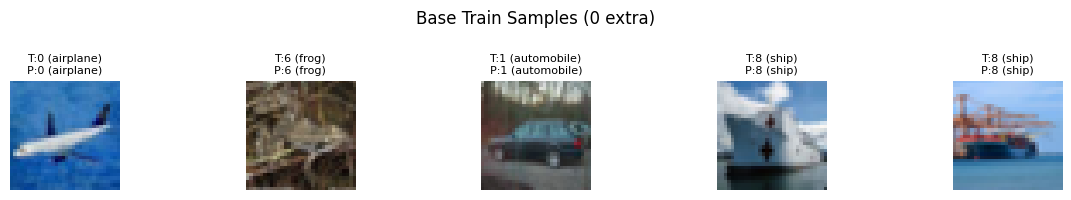

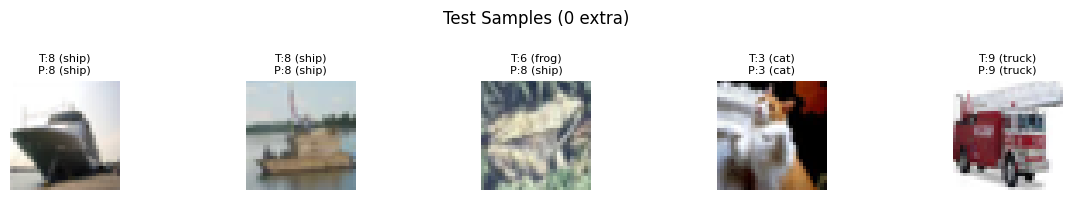

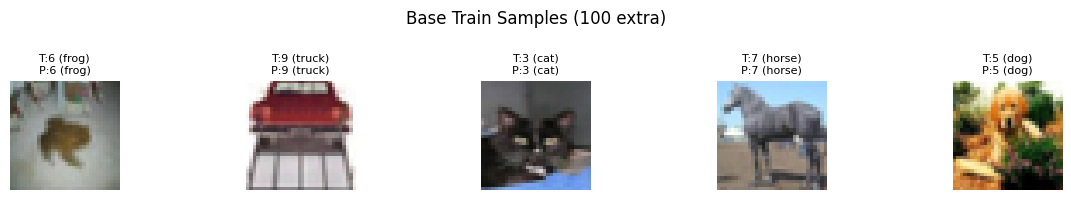

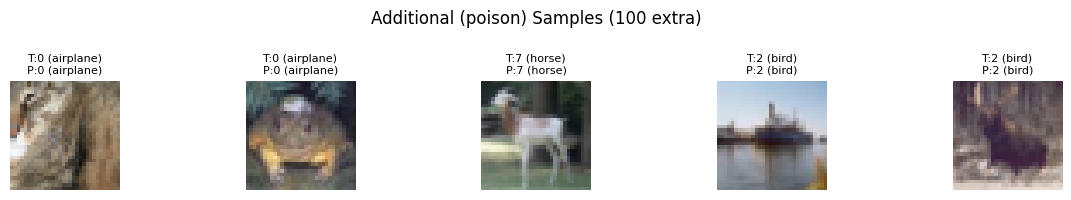

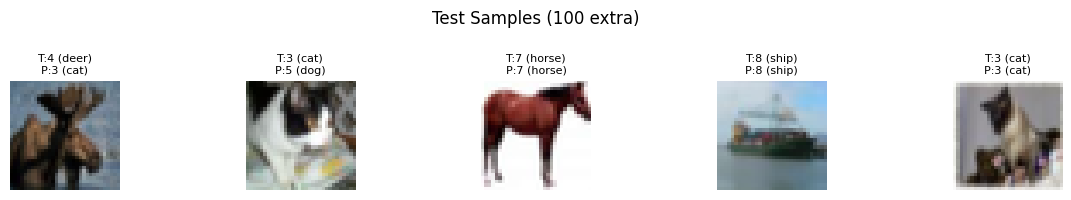

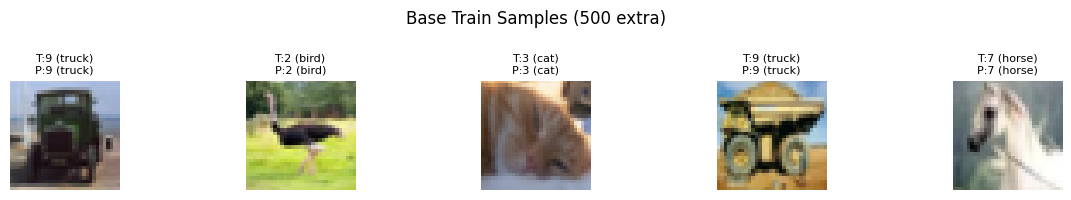

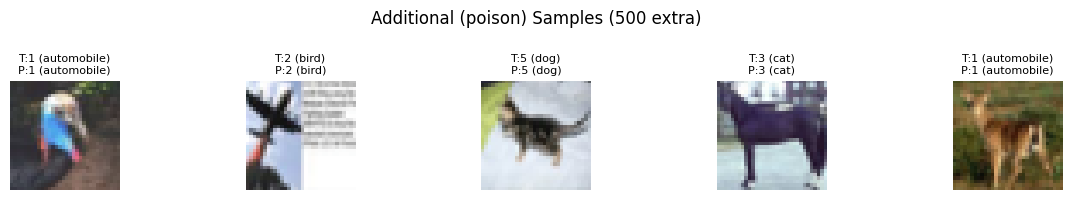

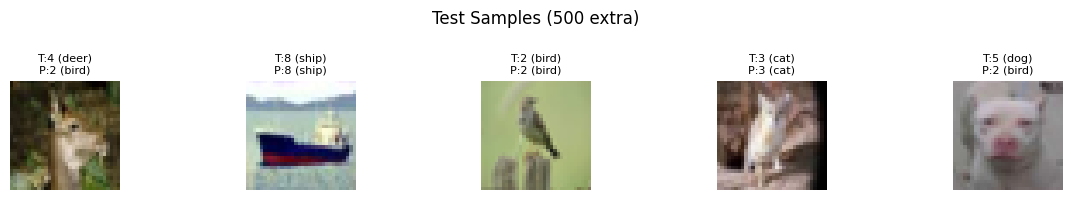

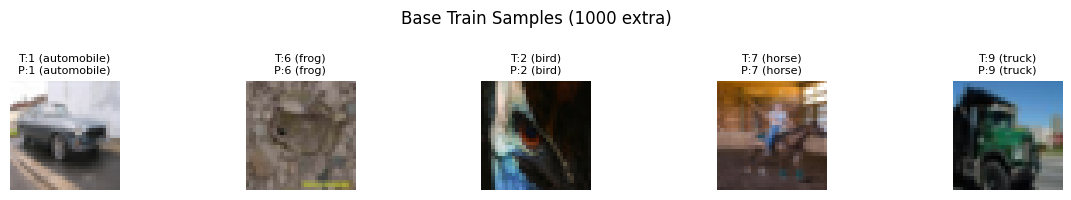

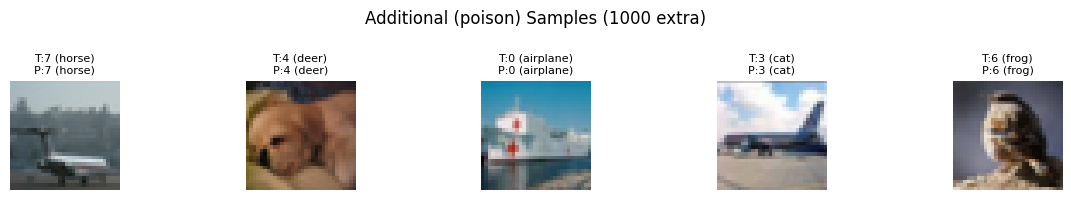

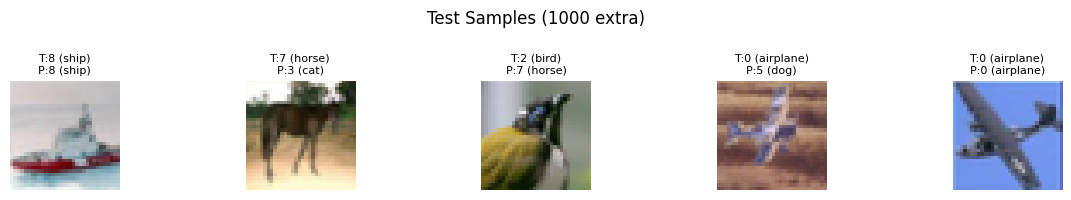

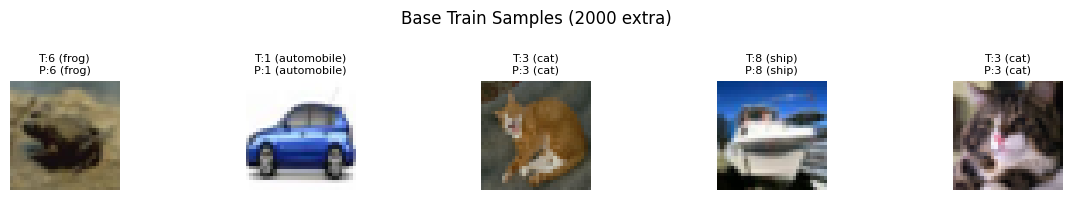

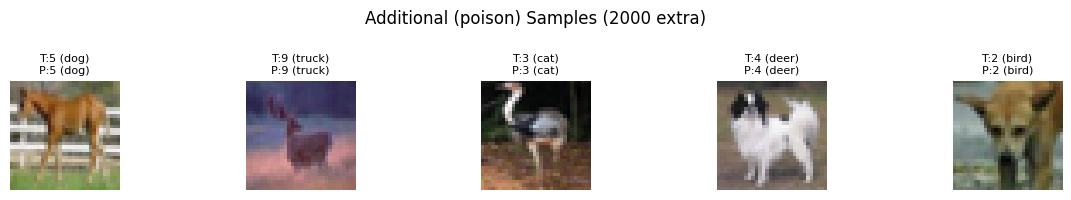

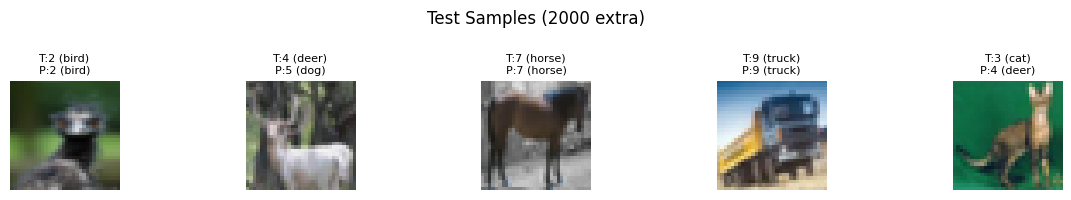

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_500.pt
Saved model: models_and_data/model_additional_500.pt
✅ Model saved to models_and_data\model_additional_1000.pt
Saved model: models_and_data/model_additional_1000.pt
✅ Model saved to models_and_data\model_additional_2000.pt
Saved model: models_and_data/model_additional_2000.pt
